<a href="https://colab.research.google.com/github/bsureshkrishna/qlsc600_2025/blob/main/PointProcesses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some text from From https://github.com/btel/python-in-neuroscience-tutorials/blob/master/poisson_process.ipynb

Neurons communicate (mainly) by action potentials also called spikes. Most information about the perceptions, decisions and actions are encoded into the sequence of spikes occuring at specific times. However, when looking at the statistics of spikes recorded from cortical neurons in vivo, the spike occurances are very irregular. Mathematically, such irregular events are described by the Poisson process and Poisson distribution. Below we will simulate Poisson processes imitating the neuronal spikes and introduce several statistics for describing them.

Imagine that every day on your way to work you count all the red Fiats that you see on the road. We call each such an encounter an event. I think we can safely assume that these events have following properites:

events occur randomly with fixed probability,
events are independent of each other, i.e. the times of the following events do not depend on the time of the previous event.

Poisson process is a random sequence of the number of such events occuring in fixed intervals of time (let's say a number of red Fiats you saw each day). In case of neurons Poisson process could describe a number of spikes registered in fixed time intervals (usually called bins). The simplest way to simulate such a process is to use the Bernoulli approximation in which the bin is chosen small enough that at most only a single event can appear within each of them.

In the implementation we will simply determine the probability of spiking in each bin and then toss a coin and mark as heads with that probability for each bin. This is not the most efficient way to generate a Poisson process, but it works for now. It will fail if spike-rate is high.. why ?

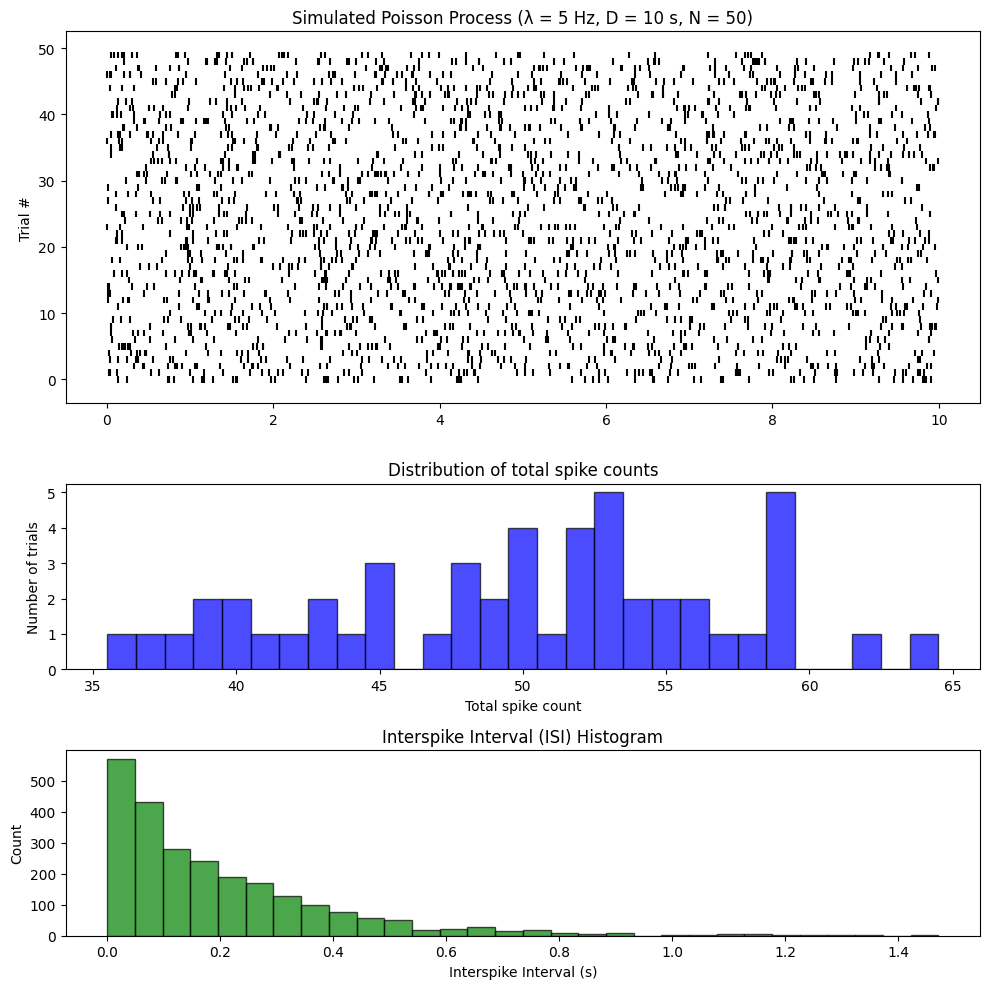

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, skewnorm, binom, poisson
from scipy.integrate import quad
import math
import sklearn
from numpy import real, pi

def simulate_poisson_process(D, lambda_rate, N=10):
    dt = 0.001  # 1 ms bin size
    num_bins = int(D / dt)  # Total bins
    p = 1 - np.exp(-lambda_rate * dt)  # Probability of event in each bin

    trials = []
    spike_counts = []
    all_isis = []

    for _ in range(N):
        events = np.random.binomial(1, p, num_bins)  # Generate spikes
        event_times = np.where(events == 1)[0] * dt  # Convert indices to time
        trials.append(event_times)
        spike_counts.append(len(event_times))

        # Compute interspike intervals (ISI) if more than one event in trial
        if len(event_times) > 1:
            isis = np.diff(event_times)  # Differences between consecutive spikes
            all_isis.extend(isis)

    return trials, spike_counts, all_isis

# Parameters
D = 10  # Duration in seconds
lambda_rate = 5  # Mean rate in Hz
N = 50  # Number of trials

# Simulate N trials
trials, spike_counts, all_isis = simulate_poisson_process(D, lambda_rate, N)

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1, 1]})

# 1. Raster Plot
for i, trial in enumerate(trials):
    axes[0].eventplot(trial, lineoffsets=i, colors='black')
axes[0].set_ylabel("Trial #")
axes[0].set_title(f"Simulated Poisson Process (λ = {lambda_rate} Hz, D = {D} s, N = {N})")

# 2. Histogram of total spike counts per trial
axes[1].hist(spike_counts, bins=np.arange(min(spike_counts), max(spike_counts) + 2) - 0.5, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Total spike count")
axes[1].set_ylabel("Number of trials")
axes[1].set_title("Distribution of total spike counts")

# 3. Interspike Interval (ISI) Histogram
if all_isis:
    axes[2].hist(all_isis, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[2].set_xlabel("Interspike Interval (s)")
    axes[2].set_ylabel("Count")
    axes[2].set_title("Interspike Interval (ISI) Histogram")

plt.tight_layout()
plt.show()


The Poisson distribution is a probability distribution that describes the number of events occurring at a specific rate in a fixed time interval. We already saw one example of such distribution in the histogram above. This distribution is parameterised by a single parameter  λ  which is simply the product of rate and the length of the time interval.

The probability of observing \( k \) events in a Poisson process with mean rate \( lambda \) is given by:

$$
P(k; \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

where:

- \( k \) is the number of events (0, 1, 2, ...),
- \( lambda \) is the expected number of events (mean rate),
- \( e \) is Euler's number (\(\approx 2.718\)).

Note that Poisson distribution is a discrete probability distriburion, which means that  k  can have only integer values.

The interspike interval distribution is exponential, so we can directly use that to simulate the expected number of counts and the expected inter-spike interval as below. In the code block after that, we will present a more general and efficient way to simulate the Poisson process.

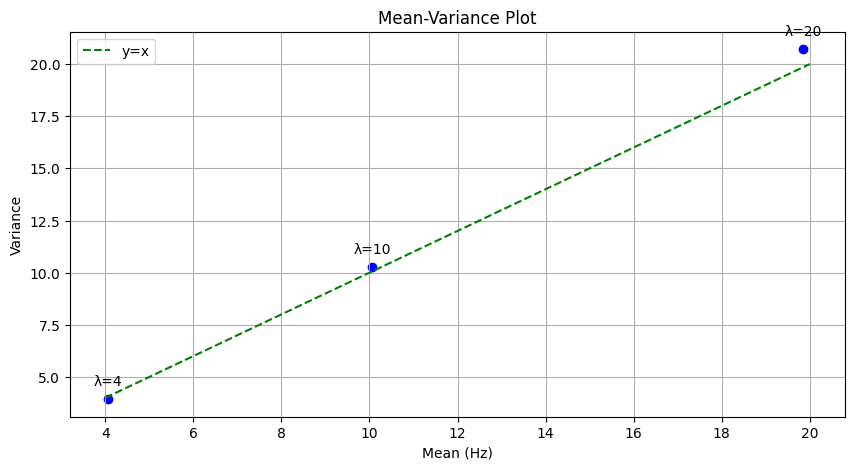

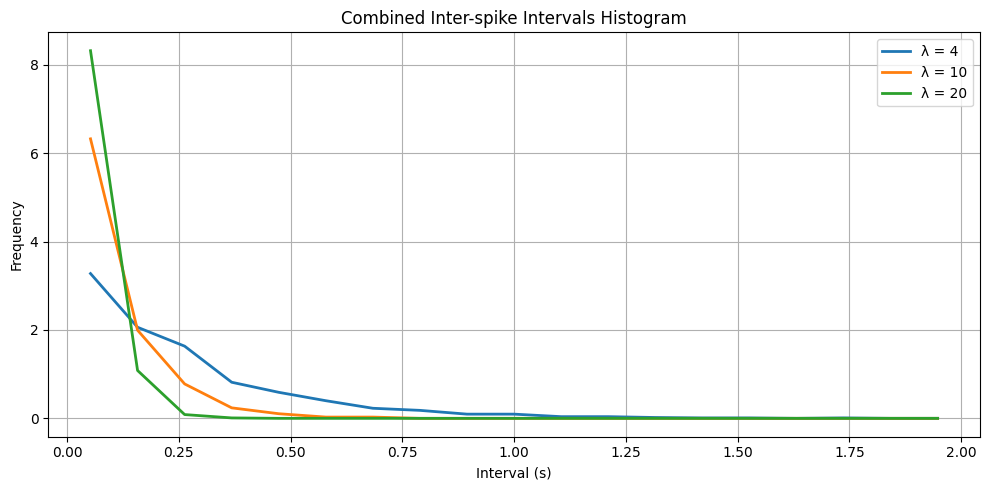

In [16]:
# Define the number of samples to generate for each Poisson process
n_samples = 1000

# Define different values for lambda (mean rate of the Poisson process)
lambdas = [4, 10, 20]

# Initialize lists to hold means and variances
means = []
variances = []

# Simulate the Poisson process for each lambda
for lam in lambdas:
    # Generate n_samples from Poisson distribution with mean `lam`
    samples = np.random.poisson(lam=lam, size=n_samples)

    # Calculate the mean and variance for the samples
    mean = np.mean(samples)
    variance = np.var(samples)

    # Append the calculated mean and variance to the lists
    means.append(mean)
    variances.append(variance)

# Prepare the figure for combined mean-variance plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot the means and variances on the same plot
ax1.scatter(means, variances, color='blue')
for i, lam in enumerate(lambdas):
    ax1.annotate(f'λ={lam}', (means[i], variances[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Plot the line y=x to represent where the mean equals the variance
ax1.plot(lambdas, lambdas, color='green', linestyle='--', label='y=x')

# Set labels and title
ax1.set_title('Mean-Variance Plot')
ax1.set_xlabel('Mean (Hz)')
ax1.set_ylabel('Variance')
ax1.legend()
ax1.grid(True)

# Prepare the figure for combined inter-spike intervals histogram with shared axes
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
bins = np.linspace(0, 2, 20)  # Bin edges for all plots

# Plot the inter-spike intervals for each lambda on the same axes
for lam in lambdas:
    inter_spike_intervals = np.random.exponential(scale=1/lam, size=n_samples)
    hist_values, bin_edges = np.histogram(inter_spike_intervals, bins=bins, density=True)

    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax2.plot(bin_centers, hist_values, label=f'λ = {lam}', linewidth=2)

# Set labels and title for the inter-spike intervals histogram
ax2.set_title('Combined Inter-spike Intervals Histogram')
ax2.set_xlabel('Interval (s)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Note: The plt.show() command is omitted here since only the code was requested.
plt.show()

We now simulate an inhomogeneous Poisson process using the time-rescaling method. There are other methods as well.. e.g. thinning, that we will not cover here. For homogeneous processes, just simulating an exponential distribution for the inter-event times is perhaps the easiest.

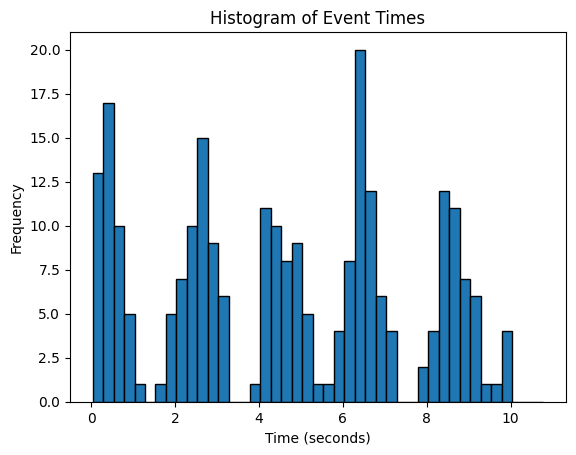

In [17]:
def simulate_inhomogeneous_poisson(times, rate_function):

    rate_function = np.clip(rate_function, 0, None)  # Clips negative values to zero
    # Integrate the rate function to get the compensator (cumulative rate function)
    compensator = np.cumsum(rate_function) * (times[1] - times[0])
    # Generate a standard Poisson process with rate 1
    n_events = np.random.poisson(compensator[-1])
    standard_poisson_events = np.sort(np.random.uniform(0, compensator[-1], n_events))

    # Apply the inverse of the cumulative rate function to the event times
    # We find where each standard Poisson event would fall in the compensator
    inhomogeneous_poisson_events = np.searchsorted(compensator, standard_poisson_events, side='left')
    inhomogeneous_poisson_events_times = times[inhomogeneous_poisson_events]

    return inhomogeneous_poisson_events_times

# Example usage:
times = np.linspace(0, 10, 10000)  # Define the time points
rate_function = np.sin(2.0*np.pi*0.5*times) * 25 + 25  # Define the rate function, ensuring it is non-negative
events = simulate_inhomogeneous_poisson(times, rate_function)
# Now 'events' contains the event times of the inhomogeneous Poisson process'

# Create a histogram
plt.hist(events, bins=np.arange(min(events), max(events)+1,0.25), edgecolor='black')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Event Times')
plt.show()

Now play with  this code. Try different rate functions.

Generate a homogeneous poisson process instead (how) ? You just have to give the right rate-function.